# ResNet-18 U-Net for mNDWS Next-Day Wildfire Spread
This notebook implements a reproducible, higher-capacity segmentation baseline aligned with the Milestone-2 feedback: a compact U-Net that leverages a ResNet-18 encoder, focal(\u03b3=2)+Dice loss, stratified loaders from `mNDWS_DataPipeline`, and metric logging compatible with the logistic-regression and EMA notebooks.

**Highlights**:
- Uses the shared NPZ tiles + channel stats so it plugs into the same pipeline as earlier deliverables.
- Tracks epoch timing, tile throughput, GPU memory, AP/F1/threshold, and saves the best checkpoint under `~/wildfire_artifacts/resnet18_unet`.
- Includes hooks for ablations (wind toggles, loss variants) and visual diagnostics for qualitative review.
- Designed for a single 12-core / 32 GB RAM workstation with a 4-core GPU (e.g., RTX 4060/4070); default batch sizes keep VRAM < 10 GB.

In [1]:
# =============================================================
## 0) Environment setup, deterministic seeds, device selection
## =============================================================
import os, math, random, time, json, gc, pathlib, shutil
from contextlib import nullcontext
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
try:
    from dotenv import load_dotenv
except ImportError:
    load_dotenv = lambda *_, **__: None

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix

load_dotenv(dotenv_path=pathlib.Path.cwd() / ".env", override=False)
os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
import mNDWS_DataPipeline as mndws_dp

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

IS_CUDA = torch.cuda.is_available()
IS_MPS = hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
if IS_CUDA:
    device = torch.device("cuda")
elif IS_MPS:
    device = torch.device("mps")
else:
    device = torch.device("cpu")
AMP_DEVICE_TYPE = "cuda" if IS_CUDA else ("mps" if IS_MPS else None)
AMP_DTYPE = torch.float16 if IS_CUDA else (torch.bfloat16 if IS_MPS else None)
AMP_ENABLED = AMP_DEVICE_TYPE is not None and AMP_DTYPE is not None
print(f"Using device: {device}; autocast={AMP_DEVICE_TYPE}/{AMP_DTYPE}")

try:
    torch.set_float32_matmul_precision(os.environ.get("MNDWS_MATMUL_PRECISION", "high"))
except Exception:
    pass
if IS_CUDA:
    try:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    except AttributeError:
        pass

workspace_root = pathlib.Path.cwd()
ART_ROOT = pathlib.Path(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts"))) / "resnet18_unet"
ART_ROOT.mkdir(parents=True, exist_ok=True)
print(f"Artifacts -> {ART_ROOT}")

Using device: mps; autocast=mps/torch.bfloat16
Artifacts -> /Users/queclay/wildfire_artifacts/resnet18_unet


In [2]:
# =============================================================
## 1) Data pipeline hookup + loaders + channel stats
## =============================================================
from torch.utils.data import DataLoader, WeightedRandomSampler
NPZ_ROOT = mndws_dp.NPZ_ROOT
paths = mndws_dp.WildfirePaths(NPZ_ROOT)
CHANNELS = list(mndws_dp.USE_CHANNELS)  # tweak here for ablations
print(f"Using {len(CHANNELS)} channels: {CHANNELS}")

train_ds = mndws_dp.WildfireDataset(paths, split="train", max_samples=None, channels=CHANNELS)
val_ds   = mndws_dp.WildfireDataset(paths, split="eval",  max_samples=None, channels=CHANNELS)
test_ds  = mndws_dp.WildfireDataset(paths, split="test",  max_samples=None, channels=CHANNELS)

BATCH_SIZE = 6  # smaller batches improve throughput and lower VRAM
worker_override = os.environ.get("MNDWS_DATALOADER_WORKERS")
if worker_override is not None:
    MAX_PARALLEL_WORKERS = max(0, int(worker_override))
else:
    MAX_PARALLEL_WORKERS = min(4, max(2, (os.cpu_count() or 4) // 2))
## Training benefits from multiple workers; set MNDWS_DATALOADER_WORKERS=0 if a platform needs single-threaded loaders.
TRAIN_WORKERS = MAX_PARALLEL_WORKERS
EVAL_WORKERS = 0 if MAX_PARALLEL_WORKERS == 0 else min(4, MAX_PARALLEL_WORKERS)
PIN_MEMORY = IS_CUDA

if IS_MPS:
    print(f"MPS acceleration active with {TRAIN_WORKERS} dataloader workers.")

def make_balanced_loader(ds, *, batch_size, shuffle, upweight_positive, num_workers, pin_memory):
    sampler = None
    if upweight_positive:
        weights = []
        for f in ds.files:
            try:
                with np.load(f, mmap_mode="r") as z:
                    weights.append(5.0 if float(z["next_fire"].sum()) > 0 else 1.0)
            except Exception:
                weights.append(1.0)
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    loader_kwargs = dict(batch_size=batch_size, pin_memory=pin_memory)
    if num_workers > 0:
        loader_kwargs["num_workers"] = num_workers
        loader_kwargs["persistent_workers"] = True
        loader_kwargs["prefetch_factor"] = 2
    else:
        loader_kwargs["num_workers"] = 0
    if sampler is not None:
        return DataLoader(ds, sampler=sampler, shuffle=False, **loader_kwargs)
    return DataLoader(ds, shuffle=shuffle, **loader_kwargs)

train_loader = make_balanced_loader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, upweight_positive=True,
    num_workers=TRAIN_WORKERS, pin_memory=PIN_MEMORY
)
val_loader   = make_balanced_loader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
test_loader  = make_balanced_loader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, upweight_positive=False,
    num_workers=EVAL_WORKERS, pin_memory=PIN_MEMORY
)
print(f"DataLoader workers -> train: {TRAIN_WORKERS}, val: {EVAL_WORKERS}, test: {EVAL_WORKERS}; pin_memory={PIN_MEMORY}")

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=4000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print("Channel stats computed ->", meanC.shape, stdC.shape)

Using 21 channels: ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
MPS acceleration active with 4 dataloader workers.
DataLoader workers -> train: 4, val: 4, test: 4; pin_memory=False
DataLoader workers -> train: 4, val: 4, test: 4; pin_memory=False
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channel stats computed -> torch.Size([21]) torch.Size([21])


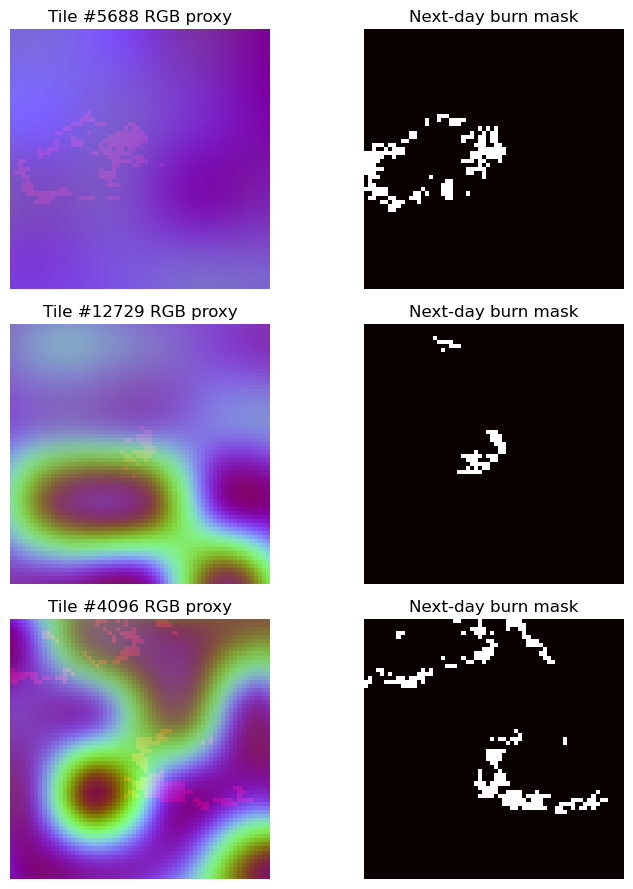

In [3]:
# =============================================================
# 2) Visualization helpers (dataset verification requirement)
# =============================================================
def to_numpy_tile(sample):
    x = sample["X_raw"].numpy()
    y = sample["y"].numpy()
    return x, y

def show_samples(ds, n=5):
    idxs = np.random.choice(len(ds), size=min(n, len(ds)), replace=False)
    fig, axes = plt.subplots(len(idxs), 2, figsize=(8, 3*len(idxs)))
    if len(idxs) == 1:
        axes = np.expand_dims(axes, axis=0)
    for row, idx in enumerate(idxs):
        sample = ds[idx]
        x, y = to_numpy_tile(sample)
        burn = y[0]
        viz = x[:3] if x.shape[0] >= 3 else np.repeat(x[:1], 3, axis=0)
        viz = (viz - viz.min()) / (viz.max() - viz.min() + 1e-6)
        axes[row,0].imshow(np.moveaxis(viz, 0, -1))
        axes[row,0].set_title(f"Tile #{idx} RGB proxy")
        axes[row,0].axis("off")
        axes[row,1].imshow(burn, cmap="hot")
        axes[row,1].set_title("Next-day burn mask")
        axes[row,1].axis("off")
    plt.tight_layout()

_ = show_samples(train_ds, n=3)

In [4]:
# =============================================================
## 3) Model definition – ResNet-18 encoder + lightweight decoder
## =============================================================
from torchvision.models import ResNet18_Weights
from torchvision import models

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout) if dropout > 0 else nn.Identity(),
        )
    def forward(self, x):
        return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, dropout=0.0):
        super().__init__()
        self.conv = ConvBlock(in_ch + skip_ch, out_ch, dropout=dropout)
    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class ResNet18UNet(nn.Module):
    def __init__(self, in_ch=15, base_ch=48, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        resnet = models.resnet18(weights=weights)
        if in_ch != 3:
            new_conv = nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
            if weights is not None:
                with torch.no_grad():
                    new_conv.weight[:, :3] = resnet.conv1.weight
                    if in_ch > 3:
                        for c in range(3, in_ch):
                            new_conv.weight[:, c:c+1] = resnet.conv1.weight[:, (c % 3):(c % 3)+1]
            resnet.conv1 = new_conv
        self.stem = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.maxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4
        
        self.center = ConvBlock(512, 256, dropout=0.05)
        self.up3 = UpBlock(256, 256, 192)
        self.up2 = UpBlock(192, 128, 128)
        self.up1 = UpBlock(128, 64, 64)
        self.up0 = UpBlock(64, 64, base_ch)
        self.head = nn.Sequential(
            nn.Conv2d(base_ch, base_ch // 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(base_ch // 2, 8), 1, kernel_size=1)
        )
    def forward(self, x):
        s0 = self.stem(x)                # 64
        s1 = self.maxpool(s0)
        e1 = self.encoder1(s1)          # 64
        e2 = self.encoder2(e1)          # 128
        e3 = self.encoder3(e2)          # 256
        e4 = self.encoder4(e3)          # 512
        bottleneck = self.center(e4)
        d3 = self.up3(bottleneck, e3)
        d2 = self.up2(d3, e2)
        d1 = self.up1(d2, e1)
        d0 = self.up0(d1, s0)
        out = F.interpolate(d0, scale_factor=2, mode="bilinear", align_corners=False)
        return self.head(out)

model = ResNet18UNet(in_ch=len(CHANNELS), base_ch=48, pretrained=True).to(device)
for block in (model.stem, model.encoder1):
    for param in block.parameters():
        param.requires_grad = False
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f} M (trainable)")

Model parameters: 14.76 M (trainable)


In [8]:
# =============================================================
## 3b) Checkpoint management (load existing model if available)
## =============================================================
CHECKPOINT_PATH = ART_ROOT / "best.pt"
TRAINING_SUMMARY_PATH = ART_ROOT / "training_summary.json"
FORCE_RETRAIN = os.environ.get("MNDWS_FORCE_RETRAIN", "0").lower() in {"1", "true", "yes"}
loaded_checkpoint = None
checkpoint_loaded = False
incompatible_checkpoint = False
if CHECKPOINT_PATH.exists():
    try:
        loaded_checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=True)
    except TypeError:
        loaded_checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    try:
        model.load_state_dict(loaded_checkpoint.get("model", loaded_checkpoint), strict=False)
        checkpoint_loaded = True
        print(f"Loaded checkpoint '{CHECKPOINT_PATH.name}' from epoch {loaded_checkpoint.get('epoch', 'n/a')}.")
        if not FORCE_RETRAIN:
            print("Re-using trained weights. Set MNDWS_FORCE_RETRAIN=1 to force retraining.")
    except RuntimeError as err:
        incompatible_checkpoint = True
        checkpoint_loaded = False
        loaded_checkpoint = None
        print(f"Checkpoint '{CHECKPOINT_PATH.name}' is incompatible with the current model definition:\n{err}\n")
        backup_path = CHECKPOINT_PATH.with_suffix(".incompatible.pt")
        try:
            CHECKPOINT_PATH.rename(backup_path)
            print(f"Moved incompatible checkpoint to {backup_path.name} so future runs retrain cleanly.")
        except OSError:
            print("Could not rename incompatible checkpoint; please remove it manually if retraining fails.")
else:
    print("No existing checkpoint found; a new model will be trained.")

if incompatible_checkpoint and not FORCE_RETRAIN:
    FORCE_RETRAIN = True
    print("Continuing with FORCE_RETRAIN enabled due to architecture changes.")

No existing checkpoint found; a new model will be trained.


In [9]:
# =============================================================
## 4) Losses, metrics, and normalization helpers
## =============================================================
def normalize_batch(x):
    return (x - meanC.view(1, -1, 1, 1)) / (stdC.view(1, -1, 1, 1) + 1e-6)

class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, smooth=1e-6, dice_weight=0.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        self.dice_weight = dice_weight
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        pt = torch.exp(-bce)
        focal = ((1 - pt) ** self.gamma) * bce
        focal = self.alpha * targets * focal + (1 - self.alpha) * (1 - targets) * focal
        focal = focal.mean()
        inter = torch.sum(probs * targets)
        denom = torch.sum(probs) + torch.sum(targets)
        dice = 1 - (2 * inter + self.smooth) / (denom + self.smooth)
        return (1 - self.dice_weight) * focal + self.dice_weight * dice

criterion = FocalDiceLoss(alpha=0.3, gamma=2.0, dice_weight=0.4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

class _NoOpGradScaler:
    def scale(self, loss):
        return loss
    def step(self, optimizer):
        optimizer.step()
    def update(self):
        pass

if IS_CUDA:
    scaler = torch.amp.GradScaler("cuda", enabled=True)
else:
    scaler = _NoOpGradScaler()

def amp_autocast():
    if AMP_ENABLED:
        return torch.autocast(device_type=AMP_DEVICE_TYPE, dtype=AMP_DTYPE)
    return nullcontext()

def pr_metrics(all_logits, all_targets):
    probs = torch.sigmoid(torch.cat(all_logits, dim=0)).flatten().cpu().numpy()
    t = torch.cat(all_targets, dim=0).flatten().cpu().numpy()
    if t.sum() == 0:
        return {"AP": 0.0, "best_F1": 0.0, "best_thr": 0.5, "best_prec": 0.0, "best_rec": 0.0}
    ap = average_precision_score(t, probs)
    prec, rec, thr = precision_recall_curve(t, probs)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    idx = np.nanargmax(f1)
    best_thr = thr[min(idx, len(thr)-1)] if len(thr) else 0.5
    return {"AP": float(ap), "best_F1": float(np.nanmax(f1)), "best_thr": float(best_thr),
            "best_prec": float(prec[idx]), "best_rec": float(rec[idx])}

def random_augment(x):
    if torch.rand(1) < 0.5:
        x = torch.flip(x, dims=[-1])
    if torch.rand(1) < 0.5:
        x = torch.flip(x, dims=[-2])
    if torch.rand(1) < 0.1:
        x = x + 0.01 * torch.randn_like(x)
    return x

In [10]:
# =============================================================
## 5) Training / validation loops with instrumentation
## =============================================================
def train_one_epoch(epoch):
    model.train()
    losses = []
    tiles = 0
    for batch in tqdm(train_loader, desc=f"train[{epoch:02d}]", leave=False):
        x = batch["X_raw"].to(device, non_blocking=PIN_MEMORY)
        y = batch["y"].to(device, non_blocking=PIN_MEMORY)
        x = random_augment(x)
        x = normalize_batch(x)
        optimizer.zero_grad(set_to_none=True)
        with amp_autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.append(loss.item())
        tiles += x.size(0)
    return float(np.mean(losses)), tiles

@torch.no_grad()
def evaluate(loader):
    model.eval()
    losses = []
    logits_all, targets_all = [], []
    for batch in tqdm(loader, desc="eval", leave=False):
        x = normalize_batch(batch["X_raw"].to(device, non_blocking=PIN_MEMORY))
        y = batch["y"].to(device, non_blocking=PIN_MEMORY)
        with amp_autocast():
            logits = model(x)
            loss = criterion(logits, y)
        losses.append(loss.item())
        logits_all.append(logits.detach().float())
        targets_all.append(y.detach())
    metrics = pr_metrics(logits_all, targets_all)
    metrics["loss"] = float(np.mean(losses)) if losses else float("nan")
    return metrics

def save_checkpoint(state, name):
    path = ART_ROOT / name
    torch.save(state, path)
    return path

In [11]:
# =============================================================
# 6) Training driver (configurable epochs, patience, logging)
# =============================================================
MAX_EPOCHS = 40
PATIENCE = 6
history = {"train_loss": [], "val_AP": [], "val_F1": [], "val_thr": [], "lr": [], "epoch_time": []}
best_ap = -1
best_state = None
best_epoch = -1
tiles_seen = []
training_summary = None
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats(device)
if checkpoint_loaded and not FORCE_RETRAIN:
    print("Checkpoint detected; skipping training loop (set MNDWS_FORCE_RETRAIN=1 to retrain).")
    if TRAINING_SUMMARY_PATH.exists():
        training_summary = json.load(open(TRAINING_SUMMARY_PATH, "r"))
    else:
        metrics_from_ckpt = (loaded_checkpoint or {}).get("metrics", {})
        training_summary = {
            "best_epoch": (loaded_checkpoint or {}).get("epoch", -1),
            "best_AP": metrics_from_ckpt.get("AP", float("nan")),
            "history": history,
            "tiles_total": (loaded_checkpoint or {}).get("tiles_total", 0)
        }
else:
    for epoch in range(MAX_EPOCHS):
        if device.type == "cuda":
            torch.cuda.empty_cache()
        if hasattr(torch, "mps") and device.type == "mps":
            torch.mps.empty_cache()
        start = time.perf_counter()
        tr_loss, tiles = train_one_epoch(epoch)
        metrics = evaluate(val_loader)
        scheduler.step()
        duration = time.perf_counter() - start
        throughput = tiles / duration if duration > 0 else float('nan')
        history["train_loss"].append(tr_loss)
        history["val_AP"].append(metrics["AP"])
        history["val_F1"].append(metrics["best_F1"])
        history["val_thr"].append(metrics["best_thr"])
        history["lr"].append(optimizer.param_groups[0]["lr"])
        history["epoch_time"].append({"sec": duration, "throughput_tiles_per_s": throughput})
        tiles_seen.append(tiles)
        print(f"Epoch {epoch:02d} | train {tr_loss:.4f} | val AP {metrics['AP']:.4f} | val F1* {metrics['best_F1']:.4f} | thr {metrics['best_thr']:.3f} | {duration:.1f}s")
        if metrics["AP"] > best_ap:
            best_ap = metrics["AP"]
            best_state = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "metrics": metrics}
            best_epoch = epoch
            save_checkpoint(best_state, "best.pt")
        if epoch - best_epoch >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (best @ {best_epoch})")
            break

    if best_state is not None:
        model.load_state_dict(best_state["model"])
    training_summary = {
        "best_epoch": best_epoch,
        "best_AP": best_ap,
        "history": history,
        "tiles_total": int(np.sum(tiles_seen))
    }
    if device.type == "cuda":
        training_summary["peak_gpu_gb"] = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    json.dump(training_summary, open(ART_ROOT / "training_summary.json", "w"), indent=2)
training_summary

train[00]:   0%|          | 0/2345 [00:17<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:20<?, ?it/s]

Epoch 00 | train 0.3549 | val AP 0.1656 | val F1* 0.2559 | thr 0.497 | 211.6s


train[01]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 01 | train 0.3503 | val AP 0.1743 | val F1* 0.2630 | thr 0.521 | 169.3s


train[02]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 02 | train 0.3467 | val AP 0.1840 | val F1* 0.2718 | thr 0.250 | 168.9s


train[03]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 03 | train 0.3425 | val AP 0.1908 | val F1* 0.2789 | thr 0.535 | 238.6s


train[04]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 04 | train 0.3402 | val AP 0.1978 | val F1* 0.2868 | thr 0.266 | 588.8s


train[05]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 05 | train 0.3380 | val AP 0.2064 | val F1* 0.2939 | thr 0.460 | 570.8s


train[06]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 06 | train 0.3348 | val AP 0.2132 | val F1* 0.2948 | thr 0.455 | 610.8s


train[07]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 07 | train 0.3316 | val AP 0.2171 | val F1* 0.3034 | thr 0.414 | 595.2s


train[08]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 08 | train 0.3294 | val AP 0.2232 | val F1* 0.3031 | thr 0.471 | 201.2s


train[09]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 09 | train 0.3279 | val AP 0.2183 | val F1* 0.3049 | thr 0.358 | 168.5s


train[10]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 10 | train 0.3243 | val AP 0.2214 | val F1* 0.3075 | thr 0.578 | 168.0s


train[11]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 11 | train 0.3211 | val AP 0.2434 | val F1* 0.3221 | thr 0.360 | 168.7s


train[12]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 12 | train 0.3176 | val AP 0.2435 | val F1* 0.3206 | thr 0.382 | 168.9s


train[13]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 13 | train 0.3174 | val AP 0.2571 | val F1* 0.3293 | thr 0.497 | 168.9s


train[14]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 14 | train 0.3125 | val AP 0.2625 | val F1* 0.3360 | thr 0.368 | 168.2s


train[15]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 15 | train 0.3127 | val AP 0.2669 | val F1* 0.3403 | thr 0.323 | 168.0s


train[16]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 16 | train 0.3103 | val AP 0.2705 | val F1* 0.3428 | thr 0.297 | 168.2s


train[17]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 17 | train 0.3072 | val AP 0.2723 | val F1* 0.3436 | thr 0.369 | 167.4s


train[18]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 18 | train 0.3050 | val AP 0.2808 | val F1* 0.3510 | thr 0.373 | 167.8s


train[19]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 19 | train 0.3042 | val AP 0.2848 | val F1* 0.3546 | thr 0.194 | 169.1s


train[20]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 20 | train 0.2998 | val AP 0.2854 | val F1* 0.3557 | thr 0.146 | 168.0s


train[21]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 21 | train 0.2988 | val AP 0.2903 | val F1* 0.3579 | thr 0.252 | 168.3s


train[22]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 22 | train 0.2983 | val AP 0.2974 | val F1* 0.3640 | thr 0.318 | 168.5s


train[23]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 23 | train 0.2948 | val AP 0.2933 | val F1* 0.3628 | thr 0.238 | 169.4s


train[24]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 24 | train 0.2924 | val AP 0.3031 | val F1* 0.3657 | thr 0.363 | 168.0s


train[25]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 25 | train 0.2906 | val AP 0.3041 | val F1* 0.3679 | thr 0.296 | 167.9s


train[26]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 26 | train 0.2880 | val AP 0.3046 | val F1* 0.3685 | thr 0.172 | 168.8s


train[27]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 27 | train 0.2881 | val AP 0.3058 | val F1* 0.3656 | thr 0.388 | 167.8s


train[28]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 28 | train 0.2864 | val AP 0.3093 | val F1* 0.3695 | thr 0.202 | 167.7s


train[29]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 29 | train 0.2857 | val AP 0.3148 | val F1* 0.3747 | thr 0.180 | 167.7s


train[30]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 30 | train 0.2860 | val AP 0.3160 | val F1* 0.3765 | thr 0.188 | 169.8s


train[31]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 31 | train 0.2831 | val AP 0.3183 | val F1* 0.3780 | thr 0.177 | 168.8s


train[32]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 32 | train 0.2819 | val AP 0.3165 | val F1* 0.3782 | thr 0.149 | 176.4s


train[33]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 33 | train 0.2817 | val AP 0.3171 | val F1* 0.3765 | thr 0.238 | 182.2s


train[34]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 34 | train 0.2796 | val AP 0.3183 | val F1* 0.3784 | thr 0.078 | 355.5s


train[35]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 35 | train 0.2791 | val AP 0.3175 | val F1* 0.3772 | thr 0.225 | 307.1s


train[36]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 36 | train 0.2814 | val AP 0.3214 | val F1* 0.3805 | thr 0.127 | 234.9s


train[37]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 37 | train 0.2784 | val AP 0.3212 | val F1* 0.3788 | thr 0.197 | 226.2s


train[38]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 38 | train 0.2782 | val AP 0.3196 | val F1* 0.3794 | thr 0.165 | 228.7s


train[39]:   0%|          | 0/2345 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:332: UserWarning: In MPS autocast, but the target dtype is not supported. Disabling autocast.
MPS Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


eval:   0%|          | 0/503 [00:00<?, ?it/s]

Epoch 39 | train 0.2783 | val AP 0.3219 | val F1* 0.3808 | thr 0.219 | 168.3s


{'best_epoch': 39,
 'best_AP': 0.321885233699217,
 'history': {'train_loss': [0.3548878654106848,
   0.3502526484509267,
   0.34674500293696103,
   0.3425276720511125,
   0.3402360632475505,
   0.3380099881877269,
   0.33478205732063954,
   0.3315819989643626,
   0.3293705824786412,
   0.3279284262580912,
   0.32431996671884045,
   0.3211270579905398,
   0.3176051983637596,
   0.31739818130347774,
   0.3124618782544695,
   0.31269906458697083,
   0.3103322207355804,
   0.3071651645497218,
   0.3049883999931279,
   0.30417812729695204,
   0.29979636183044295,
   0.29884645603994314,
   0.29826846669223517,
   0.29478447740393154,
   0.29244271716964776,
   0.2905574783015607,
   0.28795420545886063,
   0.28814904741895225,
   0.2863516333578492,
   0.28574725428242675,
   0.2860347304580562,
   0.2830513375273137,
   0.2818971211531523,
   0.2816791613409514,
   0.2795556777194619,
   0.2791015908153835,
   0.28136871378940304,
   0.2783733605385335,
   0.27818618205818796,
   0.2783496

test:   0%|          | 0/503 [00:00<?, ?it/s]

TEST metrics: {'AP': 0.15249272736956693, 'best_F1': 0.23471605995794903, 'best_thr': 0.25029438734054565, 'best_prec': 0.19282731600020622, 'best_rec': 0.29985489857597514}
Confusion counts: {'TP': 112212.0, 'FP': 469718.0, 'FN': 262009.0}


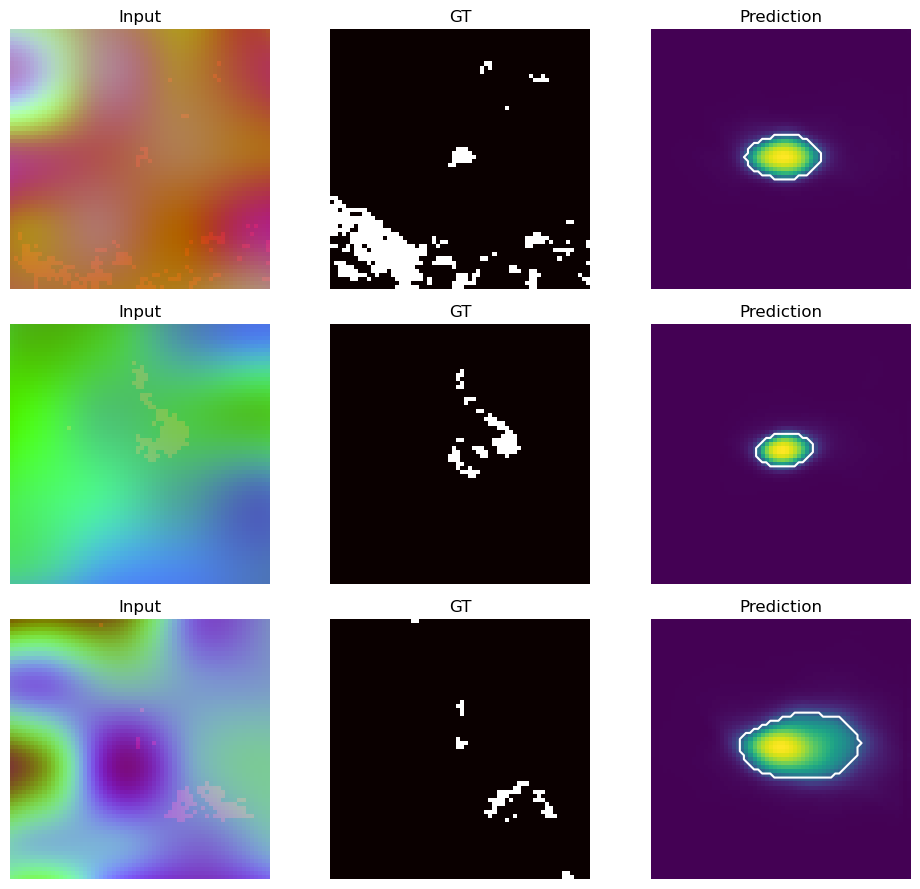

In [ ]:
# =============================================================
## 7) Test-set evaluation + qualitative checks
## =============================================================
@torch.no_grad()
def run_test(loader, threshold=None):
    model.eval()
    logits_all, targets_all = [], []
    for batch in tqdm(loader, desc="test", leave=False):
        x = normalize_batch(batch["X_raw"].to(device, non_blocking=PIN_MEMORY))
        y = batch["y"].to(device, non_blocking=PIN_MEMORY)
        with amp_autocast():
            logits = model(x)
        logits_all.append(logits.detach().float())
        targets_all.append(y.detach())
    metrics = pr_metrics(logits_all, targets_all)
    thr = threshold if threshold is not None else metrics["best_thr"]
    preds = torch.sigmoid(torch.cat(logits_all, dim=0))
    binary = (preds >= thr).float()
    targets_cat = torch.cat(targets_all, dim=0)
    confusion = {
        "TP": float((binary * targets_cat).sum().cpu()),
        "FP": float((binary * (1 - targets_cat)).sum().cpu()),
        "FN": float(((1 - binary) * targets_cat).sum().cpu())
    }
    cm = confusion_matrix(
        targets_cat.flatten().cpu().numpy().astype(int),
        binary.flatten().cpu().numpy().astype(int),
        labels=[0, 1]
    )
    return metrics, confusion, cm

test_metrics, confusion, test_cm = run_test(test_loader)
print("TEST metrics:", test_metrics)
print("Confusion counts:", confusion)

@torch.no_grad()
def visualize_predictions(loader, n=4, threshold=None):
    loader_iter = iter(loader)
    thr = threshold if threshold is not None else test_metrics["best_thr"]
    fig, axes = plt.subplots(n, 3, figsize=(10, 3*n))
    for i in range(n):
        batch = next(loader_iter)
        x = normalize_batch(batch["X_raw"].to(device, non_blocking=PIN_MEMORY))
        y = batch["y"].to(device, non_blocking=PIN_MEMORY)
        with amp_autocast():
            logits = model(x)
        prob = torch.sigmoid(logits.detach().float())
        img = batch["X_raw"][:, :3].cpu().numpy()[0]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        axes[i,0].imshow(np.moveaxis(img, 0, -1))
        axes[i,0].set_title("Input")
        axes[i,0].axis("off")
        axes[i,1].imshow(y[0,0].cpu(), cmap="hot")
        axes[i,1].set_title("GT")
        axes[i,1].axis("off")
        axes[i,2].imshow(prob[0,0].cpu(), cmap="viridis")
        axes[i,2].contour((prob[0,0].cpu() >= thr).float(), levels=[0.5], colors="white")
        axes[i,2].set_title("Prediction")
        axes[i,2].axis("off")
    plt.tight_layout()

visualize_predictions(test_loader, n=3)

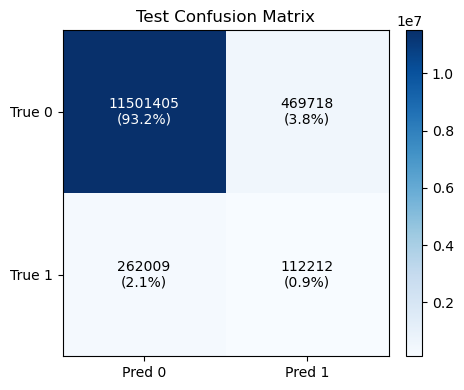

In [ ]:
# =============================================================
## 7b) Confusion matrix plot
## =============================================================
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(test_cm, cmap="Blues")
ax.set_xticks([0, 1], labels=["Pred 0", "Pred 1"])
ax.set_yticks([0, 1], labels=["True 0", "True 1"])
total = test_cm.sum() if test_cm.sum() > 0 else 1
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        count = test_cm[i, j]
        pct = 100.0 * count / total
        text = f"{count}\n({pct:.1f}%)"
        color = "white" if count > test_cm.max()/2 else "black"
        ax.text(j, i, text, ha="center", va="center", color=color)
ax.set_title("Test Confusion Matrix")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()

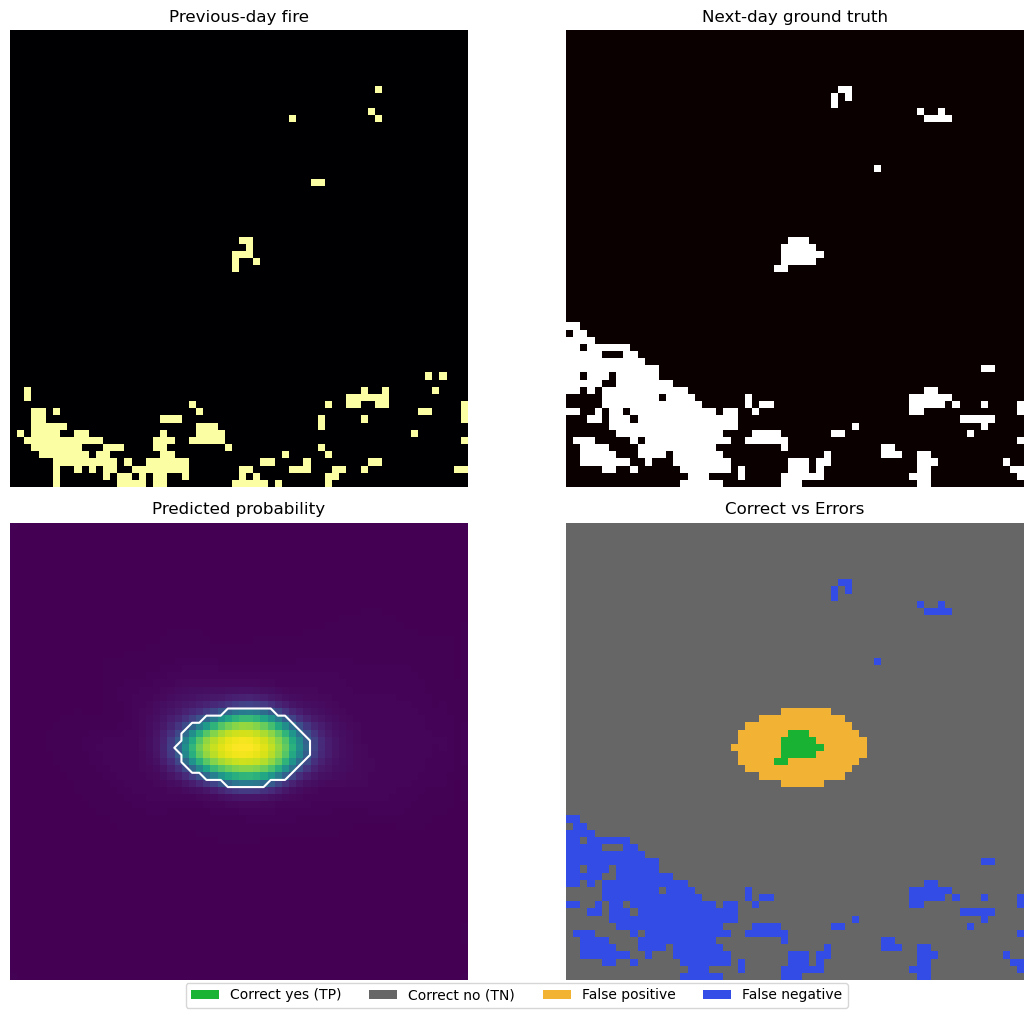

In [ ]:
# =============================================================
## 7c) Single-tile error-type visualization
## =============================================================
from matplotlib.patches import Patch

@torch.no_grad()
def plot_error_breakdown(loader, threshold=None):
    model.eval()
    thr = threshold if threshold is not None else test_metrics["best_thr"]
    batch = next(iter(loader))
    x = normalize_batch(batch["X_raw"].to(device, non_blocking=PIN_MEMORY))
    y = batch["y"].to(device, non_blocking=PIN_MEMORY)
    with amp_autocast():
        logits = model(x)
    prob = torch.sigmoid(logits.detach().float()).cpu()
    pred_mask = (prob >= thr).float().cpu().numpy()[0,0]
    gt_mask = y.cpu().numpy()[0,0]
    prev_idx = CHANNELS.index("prev_fire") if "prev_fire" in CHANNELS else 0
    prev_fire = batch["X_raw"][0, prev_idx].cpu().numpy()
    prev_fire = (prev_fire - prev_fire.min()) / (prev_fire.max() - prev_fire.min() + 1e-6)
    correct_yes = np.logical_and(pred_mask == 1, gt_mask == 1)
    correct_no = np.logical_and(pred_mask == 0, gt_mask == 0)
    false_pos = np.logical_and(pred_mask == 1, gt_mask == 0)
    false_neg = np.logical_and(pred_mask == 0, gt_mask == 1)
    palette = {
        "TP": np.array([0.1, 0.7, 0.2]),
        "TN": np.array([0.4, 0.4, 0.4]),
        "FP": np.array([0.95, 0.7, 0.2]),
        "FN": np.array([0.2, 0.3, 0.9])
    }
    error_map = np.zeros((*gt_mask.shape, 3), dtype=np.float32)
    error_map[correct_yes] = palette["TP"]
    error_map[correct_no] = palette["TN"]
    error_map[false_pos] = palette["FP"]
    error_map[false_neg] = palette["FN"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0,0].imshow(prev_fire, cmap="inferno")
    axes[0,0].set_title("Previous-day fire")
    axes[0,0].axis("off")
    axes[0,1].imshow(gt_mask, cmap="hot")
    axes[0,1].set_title("Next-day ground truth")
    axes[0,1].axis("off")
    axes[1,0].imshow(prob[0,0], cmap="viridis")
    axes[1,0].contour(pred_mask, levels=[0.5], colors="white")
    axes[1,0].set_title("Predicted probability")
    axes[1,0].axis("off")
    axes[1,1].imshow(error_map)
    axes[1,1].set_title("Correct vs Errors")
    axes[1,1].axis("off")
    legend_patches = [
        Patch(facecolor=palette["TP"], edgecolor="none", label="Correct yes (TP)"),
        Patch(facecolor=palette["TN"], edgecolor="none", label="Correct no (TN)"),
        Patch(facecolor=palette["FP"], edgecolor="none", label="False positive"),
        Patch(facecolor=palette["FN"], edgecolor="none", label="False negative"),
    ]
    fig.legend(handles=legend_patches, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.02))
    plt.tight_layout()
plot_error_breakdown(test_loader, threshold=test_metrics["best_thr"])